In [39]:
import numpy as np
import matplotlib.pyplot as pl

In [40]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

Specific arguments

In [41]:
f0 = 120
Mc = 3e-4 * 2e30
f_max = 200
T_obs = 1e4
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 40*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal

Generating signal and adding noise

In [42]:
# phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
# pl.plot(t, phi)

In [43]:
phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

nh = 50
noise = nh*np.random.normal(size = nt)
data = signal + noise

In [44]:
freqs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]-t[0]))
fft = np.fft.fftshift(np.fft.fft(data))

(0.0, 200.0)

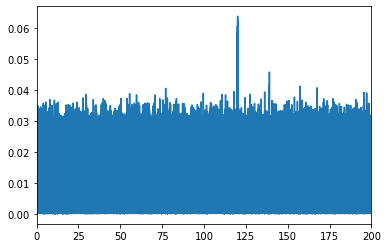

In [45]:
pl.plot(freqs[int(len(freqs)/2):-1], (2*np.abs(fft)/nt)[int(len(freqs)/2):-1])
pl.xlim(0, 200)
#Why is it not symmetric?

In [46]:
def strobo(x, tt, dt_out, t_off):
    tt /= dt_out
    tt1 = np.floor(tt)
    ii = np.nonzero(np.diff(tt1))
    out = x[ii]
    iout = tt[ii[0]]*dt_out-t_off
    return (out, iout)

In [52]:
toff = 0
f_new = f_signal/10
x = data

tt = -3/5*(1-8/3*beta*t)**(5/8)/beta
tt_new = tt*f_new
tt1 = np.floor(tt_new)
ii = np.nonzero(np.diff(tt1))[0]
out = x[ii]

In [56]:
nt_new = len(out)
corrected = np.fft.fft(out)
# freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(tt), d=tt[1]-tt[0]))

In [58]:
P2 = abs(corrected/nt_new)
P1 = P2[0:int(nt_new/2)]
P1[1:-2] = 2*P1[1:-2]
freq = f_new*np.arange(int(nt_new/2))/nt_new

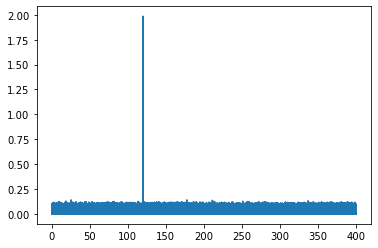

In [59]:
pl.plot(freq, P1)

In [81]:
df_thresh = freq[1] - freq[0]

In [82]:
df_thresh

0.000995381430164039

## Delta Beta

In [15]:
beta

7.969559548582883e-12

In [16]:
dPhi_thresh = 1
alpha = (1-8/3*beta*T_obs)
temp0 = dPhi_thresh/(2*pi*f0)
temp1 = alpha**(-5/8)
temp2 = (beta**(-1)+5/3*T_obs*alpha**(-1))**(-1)
dBeta_frac = temp0*temp1*temp2

In [17]:
dBeta_frac

6.3419739821109e-14

## Verifying TE

In [18]:
dBeta_arr = beta*np.linspace(0, 0.01, 100)
analytic = (1-8/3*(beta+dBeta_arr)*T_obs)**(5/8)/(beta+dBeta_arr)
TE = alpha**(5/8)/beta - dBeta_arr/beta*alpha**(5/8)*(beta**(-1)+5/3*T_obs*alpha**(-1))

Text(0.5, 0, 'dBeta')

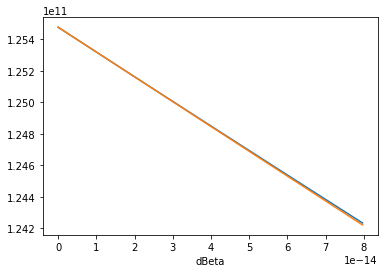

In [19]:
pl.plot(dBeta_arr, analytic, label = 'analytic')
pl.plot(dBeta_arr, TE, label = "Taylor Expansion")
pl.xlabel("dBeta")

## What if beta is a small offset away?

In [20]:
beta_wrong = 1.01*beta

In [21]:
tt = -3/5*(1-8/3*beta_wrong*t)**(5/8)/beta_wrong
tt_new = tt/dt_out
tt1 = np.floor(tt_new)
ii = np.nonzero(np.diff(tt1))[0]
out = x[ii]
nt = len(out)
corrected = np.fft.fft(out)
freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(tt), d=tt[1]-tt[0]))

P2 = abs(corrected/nt)
P1 = P2[:int(nt/2)]
P1[1:-2] = 2*P1[1:-2]
freq = 1/(dt_out)*np.arange(int(nt/2))/nt

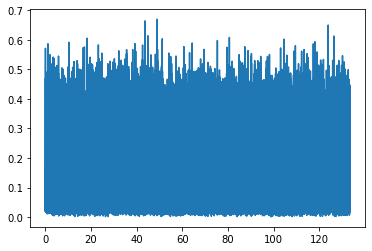

In [22]:
pl.plot(freq, P1)
#Why is the peak higher?

## Parameter space

In [23]:
def beta_calc(f, M):
    M_temp = M*2e30
    return const*f**(8/3)*M_temp**(5/3)

In [24]:
fspace = np.linspace(20, 2000, 1000)
Mspace = np.logspace(-5, -3, 1000)

[fgrid, Mgrid] = np.meshgrid(fspace, Mspace)
betaGrid = beta_calc(fgrid, Mgrid)

Text(0, 0.5, '$M_c$ ($M_\\odot$)')

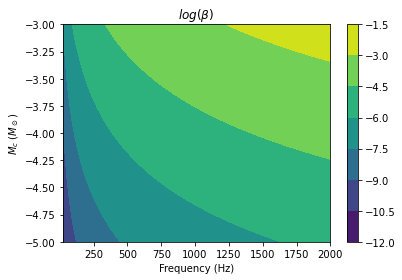

In [25]:
pl.contourf(fspace, np.log10(Mspace), np.log10(betaGrid))
pl.colorbar()
pl.title(r'$log(\beta)$')
pl.xlabel("Frequency (Hz)")
pl.ylabel(r'$M_c$ ($M_\odot$)')

In [26]:
def t_max_calc(f0, M, f_max):
    temp0 = (M/1e-2)**(-5/3)
    temp1 = (f0/200)**(-8/3) - (f_max/200)**(-8/3)
    return 1e3*temp0*temp1

def t_max_calc1(f0, beta, f_max):
    temp0 = 0.37/beta
    temp1 = 1-(f0/f_max)**(8/3)
    return temp0*temp1

In [27]:
tMax_grid = t_max_calc(fgrid, Mgrid, 2000)
tMax_grid[tMax_grid>3e7] = 3e7

/home/neil/anaconda3/envs/PBHs/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$M_c$ ($M_\\odot$)')

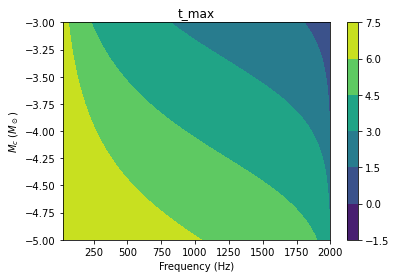

In [28]:
pl.contourf(fspace, np.log10(Mspace), np.log10(tMax_grid))
pl.colorbar()
pl.title("t_max")
pl.xlabel("Frequency (Hz)")
pl.ylabel(r'$M_c$ ($M_\odot$)')

In [29]:
tMax_grid1 = t_max_calc1(fgrid, betaGrid, 2000)
tMax_grid1[tMax_grid1>3e7] = 3e7

/home/neil/anaconda3/envs/PBHs/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$M_c$ ($M_\\odot$)')

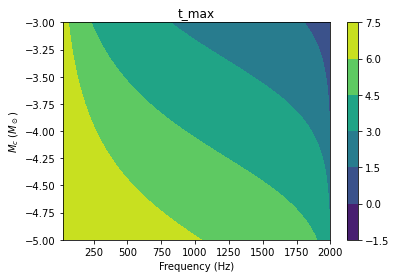

In [30]:
pl.contourf(fspace, np.log10(Mspace), np.log10(tMax_grid1))
pl.colorbar()
pl.title("t_max")
pl.xlabel("Frequency (Hz)")
pl.ylabel(r'$M_c$ ($M_\odot$)')

In [31]:
beta_space = np.logspace(-12, -1, 1000)
beta_small = 1e-7
beta_big = 1e-6
t_space = np.linspace(0, 1e4, int(1e3))
t_new_big = (1-8/3*beta_big*t_space)**(5/8)/beta_big
t_new_small = (1-8/3*beta_small*t_space)**(5/8)/beta_small